In [4]:
# Install necessary requirements
# !pip install matplotlib
# !pip install pandas
# !pip install pillow
# !pip install scipy


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.decomposition import PCA

Check if TPU is available

In [6]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, specify GPU or CPU here
    use_gpu = True  # Set this to True to use GPU or False to use CPU
    if use_gpu and tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()  # Use GPU
        print("Using GPU for TensorFlow computations.")
    else:
        strategy = tf.distribute.get_strategy()  # Use CPU
        print("Using CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

Using CPU for TensorFlow computations.


In [7]:
def show_img(path):
    image_path = path
    img = mpimg.imread(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

def read_csv_to_df(path):
    file_path =  path

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    return df

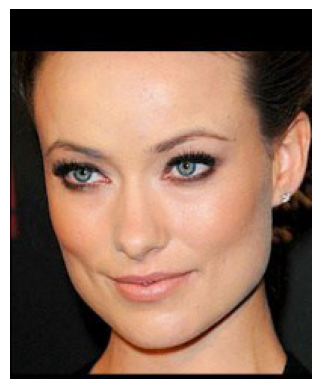

In [8]:
show_img('dataset/train/left/abn.jpg')
train_pairing_df = read_csv_to_df('dataset/train.csv')

1.  Load Training data and augment it
2.  Load Testing data

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Randomly zoom in on images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)

test_datagen = ImageDataGenerator(
    rescale=1./255)

# Set the batch size and image size
batch_size = 32
image_size = (200, 245)

# Create generators for "left" and "right" images
train_data = train_datagen.flow_from_directory(
    'dataset/train',  # Path to the "left" image folder
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode= 'input'    
)


test_data = test_datagen.flow_from_directory(
    'dataset/test/',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode= 'input'   
)


    

Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


Now Pair up the left and right images

In [10]:
def load_and_preprocess_image(image_path, target_size=(200, 245)):
    # Open the image using Pillow (PIL)
    img = load_img(image_path)
    img = img_to_array(img,dtype='int32')
    aug_image = train_datagen.random_transform(img)

    
    return img

In [11]:
# Create lists to store paired left and right images
left_images = []
right_images = []

# Iterate through the rows of the CSV file and load/preprocess the images
for index, row in train_pairing_df.iterrows():
    left_image = load_and_preprocess_image(f"dataset/train/left/{row['left']}.jpg")
    right_image = load_and_preprocess_image(f"dataset/train/right/{row['right']}.jpg")
    
    left_images.append(left_image)
    right_images.append(right_image)

# # Convert the lists to NumPy arrays or use them as needed
# left_images = np.array(left_images)
# right_images = np.array(right_images)

Now to show what pairs of images look like

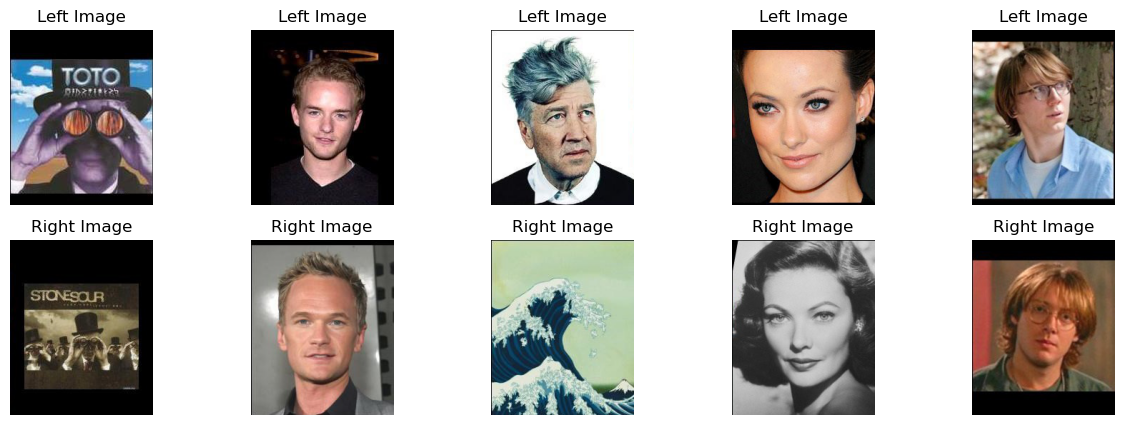

In [12]:
# Define the number of pairs to display
num_pairs_to_display = 5  # You can change this number as needed

plt.figure(figsize=(15, 5))

for i in range(num_pairs_to_display):
    plt.subplot(2, 5, i+1)  # Use 2 rows, 5 columns
    plt.imshow(left_images[i])
    plt.axis('off')
    plt.title("Left Image")

for i in range(num_pairs_to_display):
    plt.subplot(2, 5, i+num_pairs_to_display+1)  # Use 2 rows, 5 columns
    plt.imshow(right_images[i])
    plt.axis('off')
    plt.title("Right Image")

plt.show()





Now extract features using pre-trained model such as ResNet

In [13]:
def extract_resnet50_features(x):
    # Load the ResNet50 model pre-trained on ImageNet data
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(245,200, 3))
    
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features from the image
    features = model.predict(x)

    return features

def visualize_feature_maps(features, number_of_feature_to_show=10, figsize=(10, 10), cmap='viridis'):
    num_features = features.shape[-1]
    num_rows = (num_features + 4) // 5  # Calculate the number of rows needed

    plt.figure(figsize=figsize)
    for i in range(number_of_feature_to_show):
        if i < num_features:
            plt.subplot(num_rows, 5, i + 1)
            feature_map = features[0, :, :, i]

            # Resize the feature map for better visualization
            resized_feature_map = cv2.resize(feature_map, (200, 200))
            plt.imshow(resized_feature_map, cmap=cmap, interpolation='nearest')
            plt.axis('off')
            plt.title(f'Feature {i + 1}')

    plt.suptitle(f'Feature Maps Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()


In [86]:
feature_map_l1 = extract_resnet50_features(left_images[0])
feature_map_r1 = extract_resnet50_features(right_images[0])

1/1 [==============================] - 1s 1s/step


In [80]:
print(feature_map_l1.shape)
print(feature_map_r1.shape)

(1, 8, 7, 2048)
(1, 8, 7, 2048)


In [87]:
feature_vector_l1 = feature_map_l1.flatten()
feature_vector_r1 = feature_map_r1.flatten()
# Compute the dot product
similarity = np.dot(feature_vector_l1, feature_vector_r1)

In [70]:
def show_local_features(detector, image):
    img = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR)

    key_points, description = detector.detectAndCompute(img, None)
    img_keypoints = cv2.drawKeypoints(img, 
                                            key_points, 
                                            img, 
                                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
    plt.figure(figsize=(16, 16))
    plt.title('detector Interest Points')
    plt.imshow(img_keypoints); plt.show()

def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.cvtColor(img_name.astype(np.uint8), cv2.COLOR_RGB2BGR)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, img1_name, img2_name, nmatches=10):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x: x.distance) # Sort matches by distance.  Best come first.
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:nmatches], img2, flags=2) # Show top 10 matches
    plt.figure(figsize=(16, 16))
    plt.title(type(detector))
    plt.imshow(img_matches); plt.show()

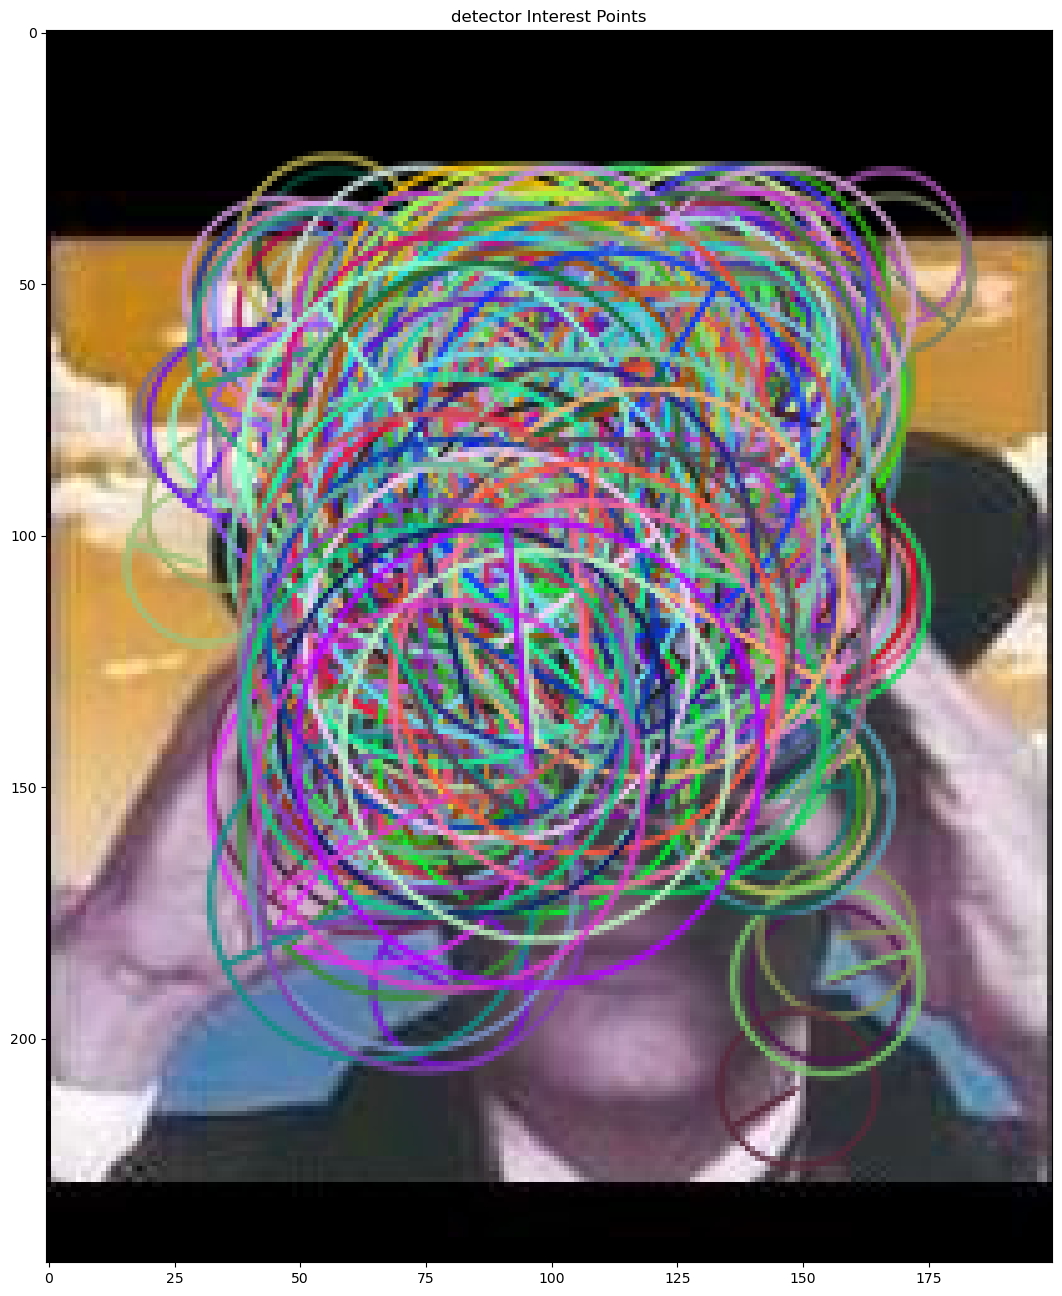

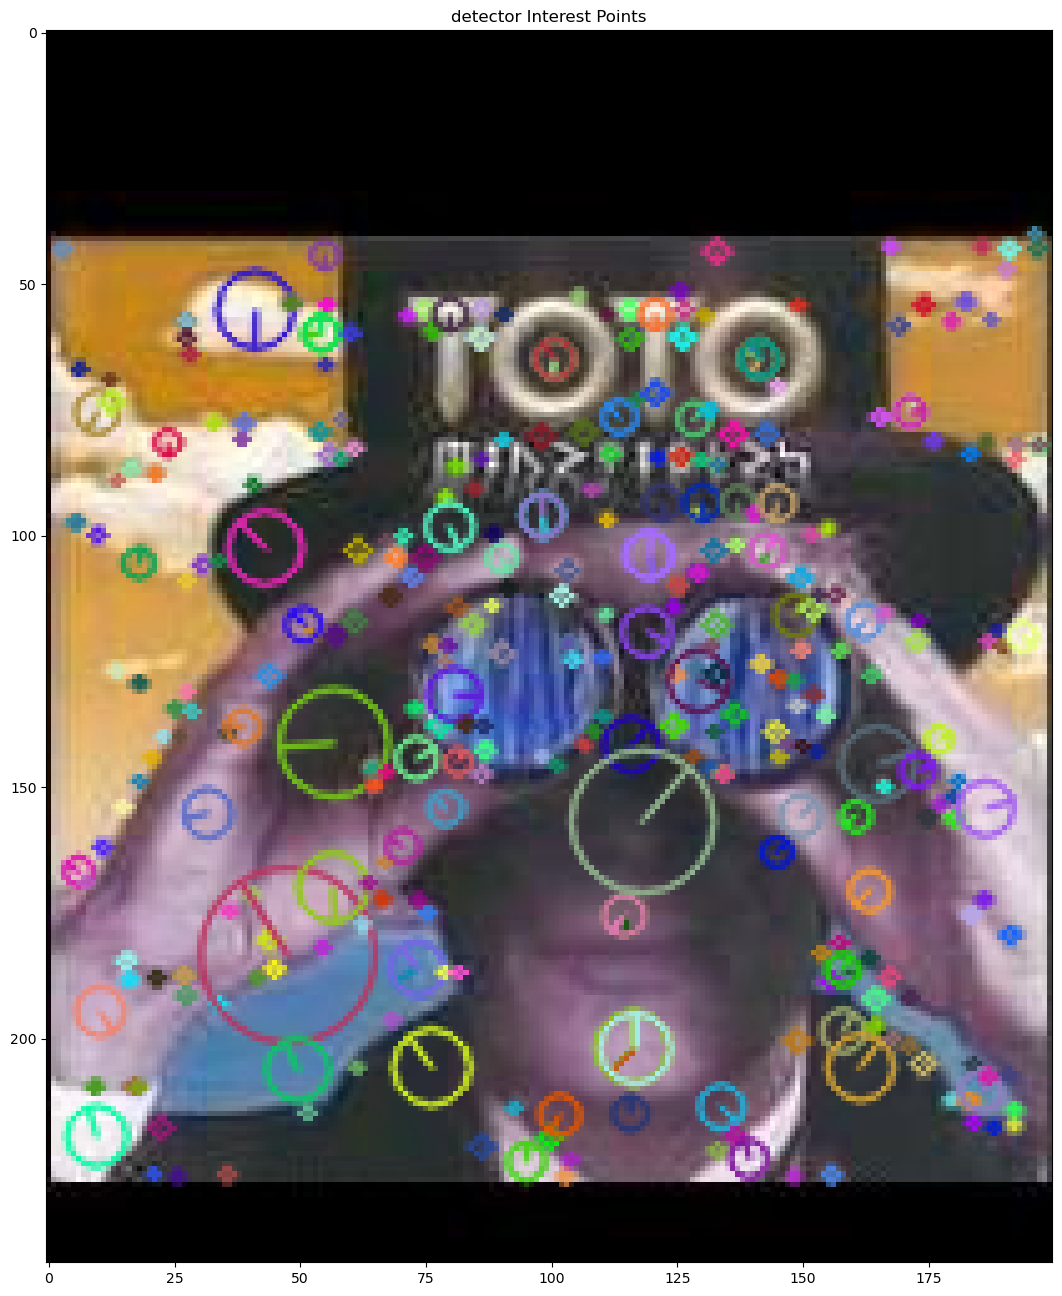

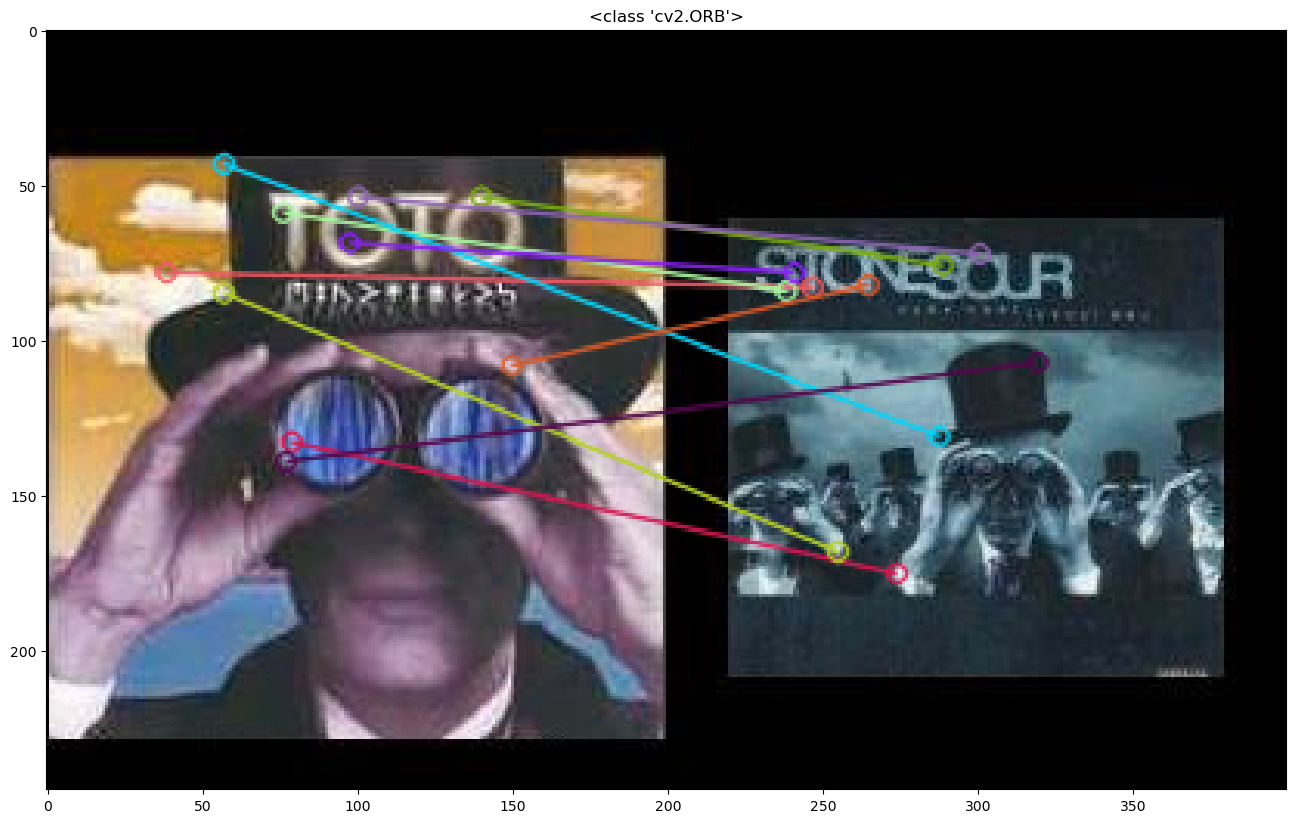

In [75]:
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

show_local_features(orb,left_images[0])
show_local_features(sift,left_images[0])
draw_image_matches(orb, left_images[0], right_images[0])


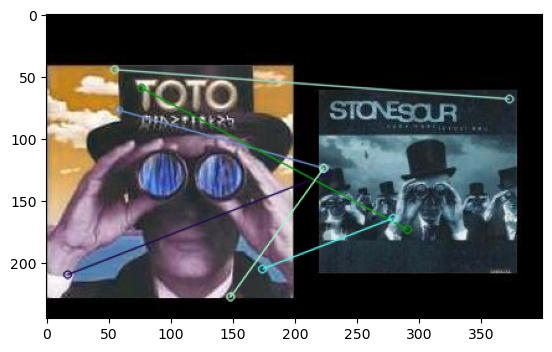

(<matplotlib.image.AxesImage at 0x261d9d022b0>, None)

In [68]:
img1 = cv2.cvtColor(left_images[0].astype(np.uint8), cv2.COLOR_RGB2BGR)
img2 = cv2.cvtColor(right_images[0].astype(np.uint8), cv2.COLOR_RGB2BGR)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

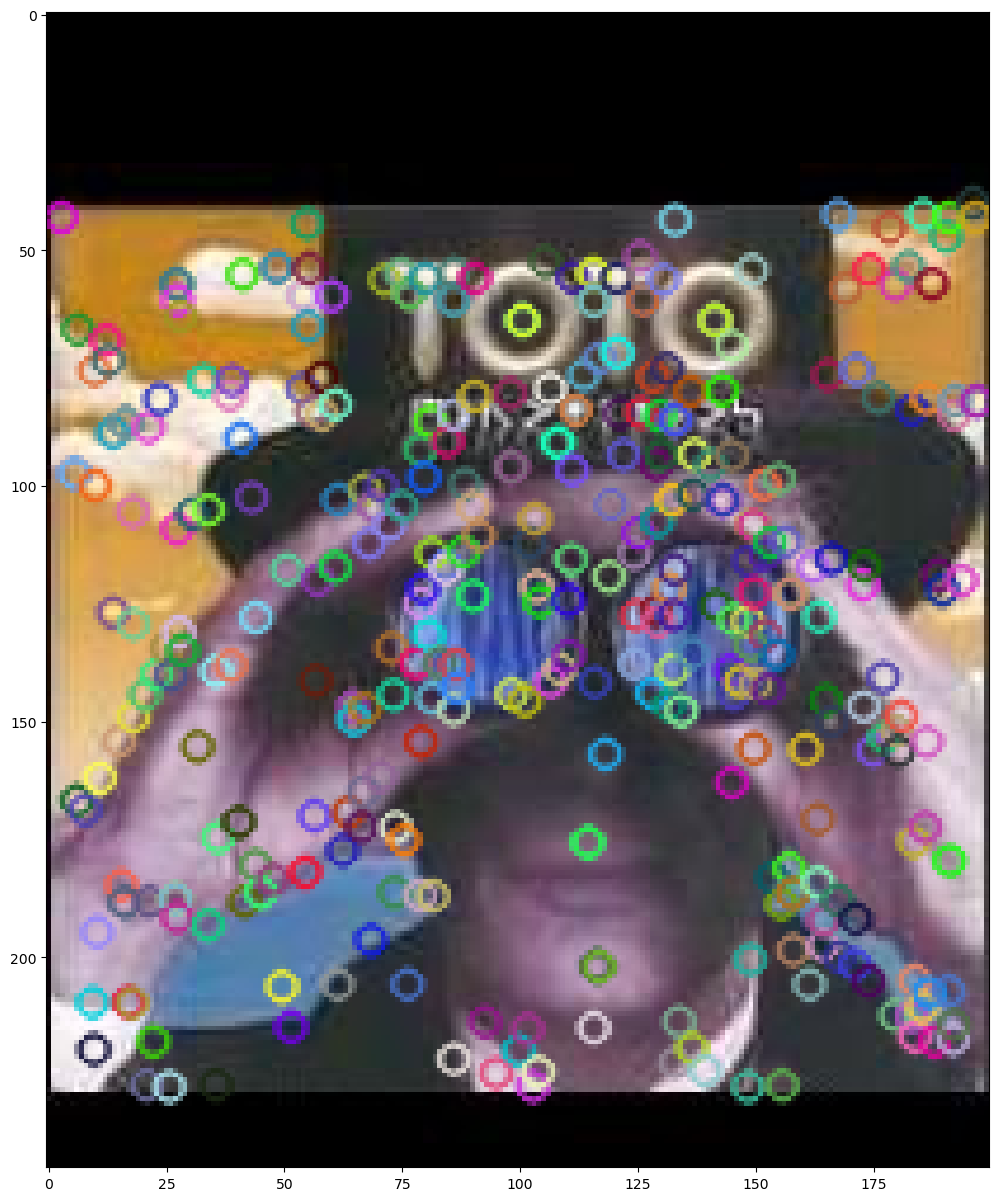

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\batch_distance.cpp:282: error: (-215:Assertion failed) (type == CV_8U && dtype == CV_32S) || dtype == CV_32F in function 'cv::batchDistance'


In [55]:
image = left_images[0]
img = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR)
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img, None)
img_kp = cv2.drawKeypoints(img, kp, img)

plt.figure(figsize=(15, 15))
plt.imshow(img_kp); plt.show()
draw_image_matches(sift, left_images[1], right_images[1])